## 実装の方針
- 予測関数側では活性化関数は不要で、**線形関数の出力をそのまま出力とする**
- 予測関数出力から **確率値を得たい場合は、予測関数出力にsoftmax関数をかける**
- **損失関数はCrossEntropyLoss関数**を利用する
- CrossEntropyLoss関数はその最終段がnn.NLLLoss関数なので、**第2引数として引き渡す正解値は、NLLLoss関数同様に整数値にする必要**がある

## 補足
- 別のやり方もあるが、一度かけた対数関数の計算結果を指数関数で元に戻す点が気持ち悪い（らしい）

## ライブラリ

In [1]:
# 必要ライブラリのインポート
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

# sklearn関連
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14
# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)
# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True
# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=4)

## データ準備

In [2]:
# データ読み込み
iris = load_iris()
# 入力データと正解データ取得
x_org, y_org = iris.data, iris.target
# 結果確認
print('元データ', x_org.shape, y_org.shape)

元データ (150, 4) (150,)


In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

0. sepal_length
1. sepal_width
2. petal_length
3. petal_width

In [4]:
# 訓練データ、検証データに分割 (シャフルも同時に実施)
x_train, x_test, y_train, y_test = train_test_split(
    x_org, y_org, train_size=75, test_size=75,
    random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# 入力次元数
n_input = x_train.shape[1]
print('入力データ(x)')
print(x_train[:5,:])
print(f'入力次元数: {n_input}')

# 出力次元数
# 分類先クラス数、今回は3になる
n_output = len(list(set(y_train)))
print(f"出力次元数: {n_output}")

(75, 4) (75, 4) (75,) (75,)
入力データ(x)
[[6.3 3.3 4.7 1.6]
 [7.  3.2 4.7 1.4]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]
 [6.3 2.5 5.  1.9]]
入力次元数: 4
出力次元数: 3


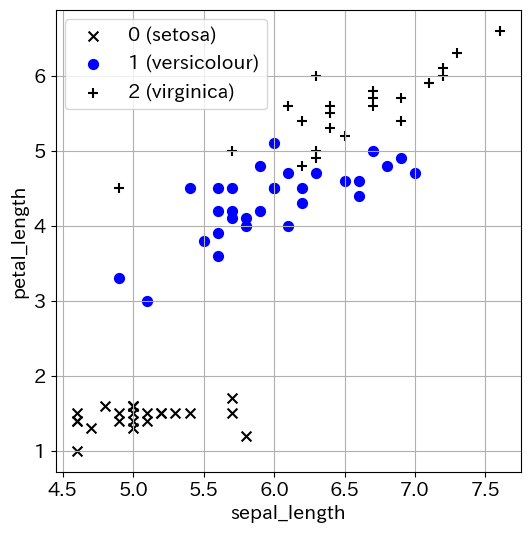

In [5]:
# データを正解値ごとに分割
x_t0 = x_train[y_train == 0]
x_t1 = x_train[y_train == 1]
x_t2 = x_train[y_train == 2]

# 散布図の表示
plt.scatter(x_t0[:,0], x_t0[:,2], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,2], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,0], x_t2[:,2], marker='+', c='k', s=50, label='2 (virginica)')
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()

## モデル定義

In [6]:
# モデル定義
# 4入力3出力のロジスティック回帰モデル

class Net(nn.Module):
    def __init__(self, n_input, n_output):
        super(Net, self).__init__()
        self.l1 = nn.Linear(n_input, n_output, bias=True)

        # 初期値を全部1にする
        # 前著"ディープラーニングの数学"と条件を合わせる目的
        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)
    
    def forward(self, x):
        x1 = self.l1(x)
        return x1
    
# インスタンスの生成
net = Net(n_input, n_output)

In [7]:
# モデルの概要表示
print(net)

Net(
  (l1): Linear(in_features=4, out_features=3, bias=True)
)


In [8]:
# モデルのサマリー表示
summary(net, (n_input,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [3]                       --
├─Linear: 1-1                            [3]                       15
Total params: 15
Trainable params: 15
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

## 損失関数などの設定

In [9]:
# 学習率
lr = 0.01

# 初期化
net = Net(n_input, n_output)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 10000

# 評価結果記録用
history = np.zeros((0,5))

## データのテンソル化

In [10]:
# 入力データ x_train と正解データ y_train のテンソル変数化
inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).long()

# 検証用データのテンソル変数化
inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).long()

## 計算グラフ可視化

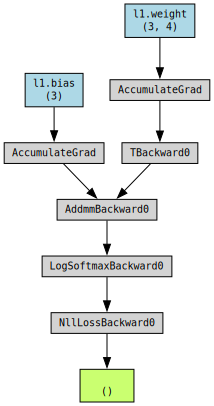

In [11]:
# 予測計算
outputs = net(inputs)

# 損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 補足: 予測値ラベルの取得方法
- 本来softmaxを通した後の値の中で一番大きい値を予測値とする
- softmax関数は、通す前と後で大小は変わらない
- softmax関数を通す前の値を取得すれば、それが予測ラベルになる

In [12]:
# torch.max関数呼び出し
# 二つ目の引数は軸を意味している。1だと行ごとの集計
print(torch.max(outputs, 1))

torch.return_types.max(
values=tensor([16.9000, 17.3000, 10.8000, 17.9000, 16.7000, 11.7000, 10.5000, 15.2000,
        16.4000, 19.1000, 12.2000, 10.7000, 13.8000, 11.4000, 16.7000, 18.5000,
        10.7000, 17.8000, 13.0000, 12.5000, 17.4000, 10.4000, 11.8000, 16.4000,
        19.3000, 16.4000, 14.4000, 14.1000, 10.4000, 11.1000, 16.8000, 16.7000,
        10.7000, 11.4000, 14.8000, 16.5000, 15.7000, 19.1000, 17.4000, 14.6000,
        14.9000, 20.3000, 11.1000, 11.7000, 15.6000, 19.1000, 17.8000, 19.2000,
        17.7000, 11.2000, 15.4000, 10.4000, 14.6000, 15.3000, 10.9000, 15.4000,
        18.8000, 15.9000, 19.2000, 17.3000, 11.9000, 15.8000, 10.4000, 18.3000,
        16.2000, 15.1000, 12.6000, 16.7000, 14.6000, 16.4000, 11.3000, 12.7000,
        15.6000, 16.6000, 20.4000], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 

## メインループ

In [13]:
for epoch in range(num_epochs):

    # 訓練フェーズ

    #勾配の初期化
    optimizer.zero_grad()

    # 予測計算
    outputs = net(inputs)

    # 損失計算
    loss = criterion(outputs, labels)

    # 勾配計算
    loss.backward()

    # パラメータ修正
    optimizer.step()

    #予測値算出
    predicted = torch.max(outputs, 1)[1]

    # 損失と精度の計算
    train_loss = loss.item()
    train_acc = (predicted == labels).sum()  / len(labels)

    #予測フェーズ

    # 予測計算
    outputs_test = net(inputs_test)

    # 損失計算
    loss_test = criterion(outputs_test, labels_test)

    # 予測ラベル算出
    predicted_test = torch.max(outputs_test, 1)[1]

    # 損失と精度の計算
    val_loss =  loss_test.item()
    val_acc =  (predicted_test == labels_test).sum() / len(labels_test)

    if ( epoch % 10 == 0):
        print (f'Epoch [{epoch}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
        item = np.array([epoch , train_loss, train_acc, val_loss, val_acc])
        history = np.vstack((history, item))

Epoch [0/10000], loss: 1.09861 acc: 0.30667 val_loss: 1.09158, val_acc: 0.26667
Epoch [10/10000], loss: 1.01848 acc: 0.40000 val_loss: 1.04171, val_acc: 0.26667
Epoch [20/10000], loss: 0.96854 acc: 0.40000 val_loss: 0.98850, val_acc: 0.26667
Epoch [30/10000], loss: 0.92459 acc: 0.65333 val_loss: 0.93996, val_acc: 0.57333
Epoch [40/10000], loss: 0.88568 acc: 0.70667 val_loss: 0.89704, val_acc: 0.62667
Epoch [50/10000], loss: 0.85120 acc: 0.70667 val_loss: 0.85918, val_acc: 0.62667
Epoch [60/10000], loss: 0.82059 acc: 0.70667 val_loss: 0.82572, val_acc: 0.62667
Epoch [70/10000], loss: 0.79335 acc: 0.72000 val_loss: 0.79607, val_acc: 0.62667
Epoch [80/10000], loss: 0.76900 acc: 0.72000 val_loss: 0.76968, val_acc: 0.65333
Epoch [90/10000], loss: 0.74717 acc: 0.72000 val_loss: 0.74610, val_acc: 0.65333
Epoch [100/10000], loss: 0.72750 acc: 0.76000 val_loss: 0.72494, val_acc: 0.69333
Epoch [110/10000], loss: 0.70970 acc: 0.77333 val_loss: 0.70585, val_acc: 0.74667
Epoch [120/10000], loss: 0.

## 結果確認

In [14]:
# 損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.09158 精度: 0.26667
最終状態: 損失: 0.13724 精度: 0.96000


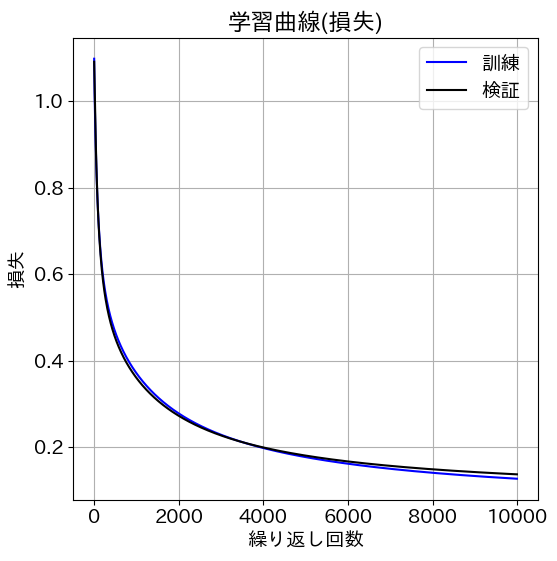

In [15]:
# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

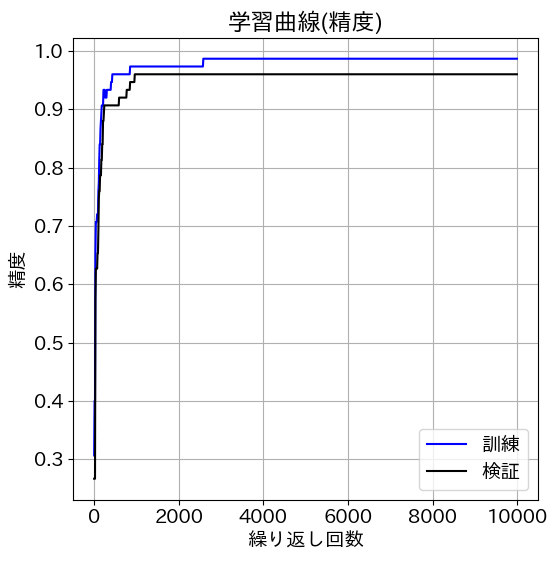

In [16]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

## モデル出力の確認
- 今回はsoftmax関数を損失関数側に含めてしまったので、モデルの出力がどんな値になっているか調べてみる
- また、出力から確率値を取得したい場合どうしたらいいかも調べる

In [17]:
# 正解データの0番目、2番目、3番目を抜き出すことにした
print(labels[[0, 2, 3]])

tensor([1, 0, 2])


In [18]:
# 該当する入力値を抽出
i3 = inputs[[0, 2, 3], :]
print(i3.data.numpy())

[[6.3 3.3 4.7 1.6]
 [5.  3.  1.6 0.2]
 [6.4 2.8 5.6 2.1]]


In [19]:
# 入力値をnetに通す。出力値を取得。
# 出力値にsoftmax関数をかけた結果を取得

softmax = torch.nn.Softmax(dim=1)
o3 = net(i3)
k3 = softmax(o3)
print(o3.data.numpy())
print(k3.data.numpy())

[[14.3224 19.3516 17.0256]
 [17.1434 14.295   0.9613]
 [11.1292 19.7008 22.8696]]
[[0.0059 0.9056 0.0885]
 [0.9452 0.0548 0.    ]
 [0.     0.0404 0.9596]]


### 重み行列とバイアスの値

In [20]:
# 重み行列
print(net.l1.weight.data)
# バイアス
print(net.l1.bias.data)

tensor([[ 1.8991,  3.0917, -1.8499, -0.3448],
        [ 1.5797,  1.1379,  0.9194, -0.1347],
        [-0.4789, -1.2295,  3.9305,  3.4794]])
tensor([1.4016, 1.5386, 0.0597])


## 決定境界の描画(うまくできない…)

In [21]:
x_axis_idx = 0
y_axis_idx = 2

# x, yの描画領域計算
x_min = x_train[:,x_axis_idx].min()
x_max = x_train[:,x_axis_idx].max()
y_min = x_train[:,y_axis_idx].min()
y_max = x_train[:,y_axis_idx].max()
x_bound = torch.tensor([x_min, x_max])

# 結果確認
print(x_bound)

tensor([4.6000, 7.6000], dtype=torch.float64)


In [22]:
# 決定境界用の１次関数定義
def d_bound(x, i, W, B):
    W1 = W[[2,0,1],:]
    W2 = W - W1
    w = W2[i,:]
    B1 = B[[2,0,1]]
    B2 = B - B1
    b = B2[i]
    v = -1/w[1]*(w[0]*x + b)
    return v

In [25]:
W

tensor([[ 1.8991,  3.0917, -1.8499, -0.3448],
        [ 1.5797,  1.1379,  0.9194, -0.1347],
        [-0.4789, -1.2295,  3.9305,  3.4794]])

In [28]:
W1 = W[[2,0,1],:]
W1

tensor([[-0.4789, -1.2295,  3.9305,  3.4794],
        [ 1.8991,  3.0917, -1.8499, -0.3448],
        [ 1.5797,  1.1379,  0.9194, -0.1347]])

In [29]:
W2 = W - W1
W2

tensor([[ 2.3780,  4.3212, -5.7804, -3.8242],
        [-0.3194, -1.9538,  2.7693,  0.2101],
        [-2.0586, -2.3674,  3.0111,  3.6141]])

In [31]:
 w = W2[0,:]
w

tensor([ 2.3780,  4.3212, -5.7804, -3.8242])

In [ ]:
# 損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

初期状態: 損失: 1.09158 精度: 0.26667
最終状態: 損失: 0.13724 精度: 0.96000


In [23]:
# 決定境界のyの値を計算

W = net.l1.weight.data
B = net.l1.bias.data

y0_bound = d_bound(x_bound, 0, W, B)
y1_bound = d_bound(x_bound, 1, W, B)
y2_bound = d_bound(x_bound, 2, W, B)

# 結果確認
print(y0_bound)
print(y1_bound)
print(y2_bound)

tensor([-2.8420, -4.4930], dtype=torch.float64)
tensor([-0.6818, -1.1723], dtype=torch.float64)
tensor([-4.6248, -7.2335], dtype=torch.float64)


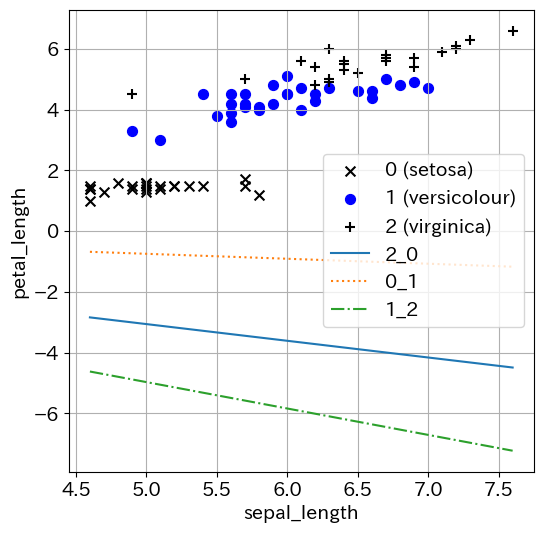

In [24]:
# 散布図と決定境界の標示

# xとyの範囲を明示的に指定
#plt.axis([x_min, x_max, y_min, y_max])

# 散布図
plt.scatter(x_t0[:,x_axis_idx], x_t0[:,y_axis_idx], marker='x', c='k', s=50, label='0 (setosa)')
plt.scatter(x_t1[:,x_axis_idx], x_t1[:,y_axis_idx], marker='o', c='b', s=50, label='1 (versicolour)')
plt.scatter(x_t2[:,x_axis_idx], x_t2[:,y_axis_idx], marker='+', c='k', s=50, label='2 (virginica)')

# 決定境界
plt.plot(x_bound, y0_bound, label='2_0')
plt.plot(x_bound, y1_bound, linestyle=':',label='0_1')
plt.plot(x_bound, y2_bound, linestyle='-.',label='1_2')

# 軸ラベルと凡例
plt.xlabel('sepal_length')
plt.ylabel('petal_length')
plt.legend()
plt.show()